# Ordinary Least Squares Linear Regression
**Further Reading:** §7.1 in Navidi (2015)

**Further Reading:** §7.2 in Navidi (2015)

## Learning Objectives

After studying this notebook and your lecture notes, you should be able to:
* Interpret correlation coefficient
* Compute simple linear regression best fits

In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import math
import matplotlib.pyplot as plt

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Review Chapter 7 in Navidi (2015).
</div>

## Motivating Example for Linear Regression

What job responsibilities do you think a chemical engineer would have in the agriculture industry?

A fellow scientist in Big Ag, Inc. planted alfalfa on several plots of land, identical except for the soil pH. The following are the dry matter yields (in pounds per acre) for each plot.

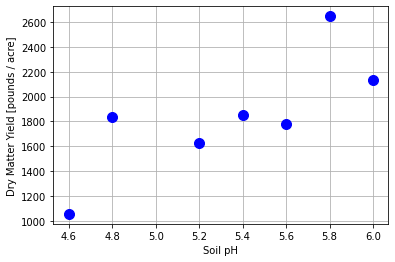

In [2]:
pH = np.array([4.6, 4.8, 5.2, 5.4, 5.6, 5.8, 6.0])
yld = np.array([1056, 1833, 1629, 1852, 1783, 2647, 2131])

plt.plot(pH,yld,'b.',markersize=20)
plt.xlabel('Soil pH')
plt.ylabel('Dry Matter Yield [pounds / acre]')
plt.grid(True)
plt.show()

Your colleague would like help analyzing these data. In particular:
1. Is the trend in the data linear?
2. Can we create a model to predict the dry matter yield based on soil pH?
3. How can we incorporate uncertainty into our model?

We will use this example throughout the lecture to introduce the fundamentals of linear regression.

## Linear Regression Basics

Based on the plot above, your colleague suggests a simple linear model:

$$y = \beta_0 + \beta_1 x + \epsilon$$

Nomenclature:
* $y$ is the yield (dependent variable, response, observed variable)
* $x$ is the pH (independent variable, feature, manipulated variable)
* $\beta_0$ is the intercept
* $\beta_1$ is the slope
* $\epsilon$ is the random observation error. More on it latter.

We cannot measure $\beta_0$ and $\beta_1$ directly. Instead, we can take paired measurements ($x_1, y_1$), ($x_2, y_2$),... ($x_n, y_n$) and find the values of $\hat{\beta}_0$ and $\hat{\beta}_1$ that cause the predictions $\hat{y}$ to best fit the data.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x$$

Nomenclature:
* $\hat{y}$ **predicted** response
* $\hat{\beta}_0$ **best fit** intercept, estimates true (unknown) intercept
* $\hat{\beta}_1$ **best fit** slope, estimates true (unknown) intercept

**Main idea**: $\hat{\beta}_0$ and $\hat{\beta}_1$ are **estimates** of the true (but unknown) intercept and slope.

## Optimization Formulation

At the heart of regression, we want to solve a least-squares minimization problem:

$$\min_{\hat{\beta}_0,\hat{\beta}_1} \quad \sum_{i}^n(y_i - \hat{y}_i)^2$$

We have done this in multiple lectures already.

## Analytic Solution

Because our model is linear, it is not that difficult to find the analytic solution to the above optimization problem.

$$\hat{\beta}_1 = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$

$$\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$$

Here $\bar{x}$ and $\bar{y}$ are the average (mean) values of the independent and dependent variables, respectively, calculated using the sample.

$$
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i, \qquad \bar{x} = \frac{1}{n} \sum_{i=1}^n x_i
$$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the following with your neighbor:
</div>

1. How can you calculate the numerator and denominator in a single line using linear algebra?
2. True/False. The best fit line always passes through ($\bar{x},\bar{y}$). Write a sentence to justify your answer.

In [3]:
x = pH
y = yld
n_farm = len(x)

# calculate averages
xbar = np.mean(x)
ybar = np.mean(y)

# calculate numerator
# num = # fill in
num = (x - xbar).dot(y - ybar)

# calculate denominator
# denom = # fill in
denom = (x - xbar).dot(x-xbar)

# calculate slope
b1 = num / denom

# calculate intercept
b0 = ybar - b1 * xbar

# print results
print("slope = ",b1,"pounds per acre / pH unit")
print("intercept =",b0,"pounds per acre")

slope =  737.1014492753624 pounds per acre / pH unit
intercept = -2090.942028985508 pounds per acre


## Scipy Package

We can do the same calculations with Scipy.

In [4]:
b1_, b0_, r_value, p_value, std_err = stats.linregress(x, y)

print("slope = ",b1_,"pounds per acre / pH unit")
print("intercept =",b0_,"pounds per acre")

slope =  737.1014492753623 pounds per acre / pH unit
intercept = -2090.9420289855075 pounds per acre


## Visualize

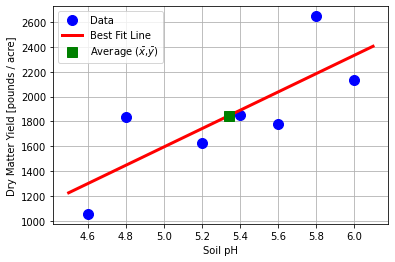

In [5]:
# generate predictions
pH_pred = np.linspace(4.5, 6.1, 20)
yld_pred = b0_ + b1_ * pH_pred

# create plot
plt.plot(pH,yld,'.b',markersize=20,label='Data')
plt.plot(pH_pred,yld_pred,'-r',linewidth=3,label='Best Fit Line')
plt.plot(xbar,ybar,'sg',markersize=10,label=r"Average ($\bar{x}$,$\bar{y}$)")
plt.xlabel('Soil pH')
plt.ylabel('Dry Matter Yield [pounds / acre]')
plt.grid(True)
plt.legend()
plt.show()